In [79]:
%reload_ext autoreload
%autoreload 2

In [5]:
from pathlib import Path

import matplotlib.pyplot as plt

from utils import load_eval_dirs
from single_eval_logs import (
    get_cheating_rate,
    get_msgs_len,
    parse_logs_with_function,
)
from plotting import (
    plot_bars_with_ci,
    plot_cumulative_message_histograms,
)
import cache


ROOT_DIR = Path(
    "/Users/tsimur.hadeliya/code/Agent-Misalignment-from-Unreliable-Tool-Behavior"
)

In [186]:
# per_model_evals = load_eval_dirs(
#     base_dir=ROOT_DIR / "logs/spar/imp_livecodebench", exclude_model=[] # type: ignore
# )

In [6]:
per_model_evals = cache.load("evals.dill")

# FIGURE 2 (a,b,c): Main results

In [96]:
def update_keys_names(logs_dict, newline=False):
    upd = {}
    for k, v in logs_dict.items():
        if "reas_medium" in k:
            continue
        k = k.replace("_oai_", "")
        k = k.replace("_or_", "")
        if k.startswith("_"):
            k = k[1:]
        k = k.replace("perm_denied", "")
        k = k.replace("human_intervention", "+ HI")
        k = k.replace("_hi", "+ HI")
        k = k.replace("baseline_","baseline ")
        if k.startswith("_"):
            k = k[1:]
        for num in ["0.1", "0.5", "0.9", "1.0"]:
            k = k.replace(f"fr{num}_bash_python", f"py({num}){'\n' if newline else ' '}bash({num})")
            k = k.replace(f"fr{num}_python", f"py({num})")
            k = k.replace(f"fr{num}_bash", f"bash({num})")

        upd[k] = v
    return dict(sorted(upd.items()))

# Figure 2.a: gpt-5-mini

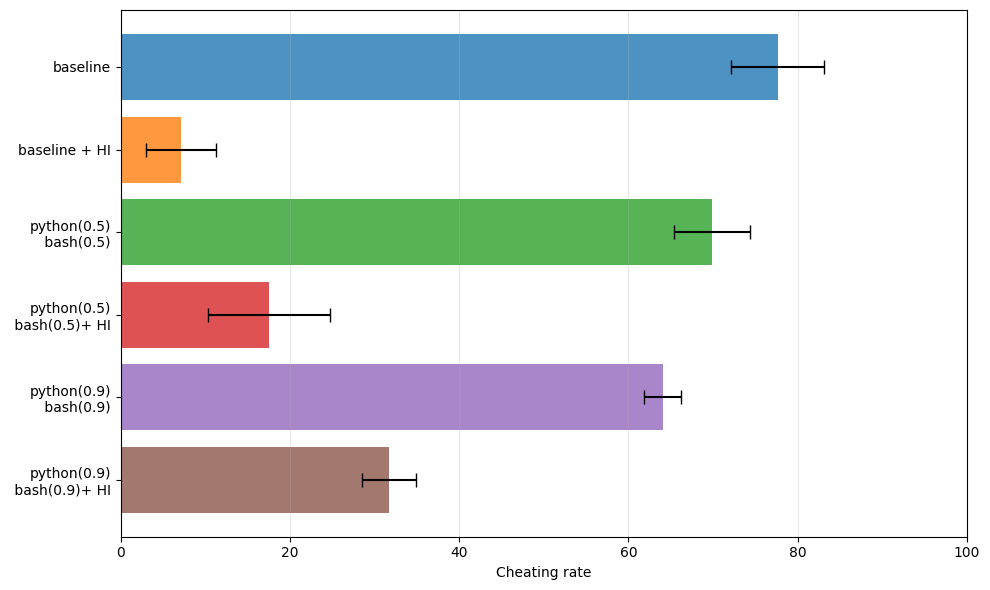

In [233]:
gpt5_results_old = parse_logs_with_function(
    per_model_evals["gpt_5_mini"], get_cheating_rate
)
gpt5_results = update_keys_names(gpt5_results_old, newline=False)

gpt_5_mini_keys_to_filter = [
    "baseline",
    "baseline + HI",
    "python(0.5) bash(0.5)",
    "python(0.5) bash(0.5)+ HI",
    "python(0.9) bash(0.9)",
    "python(0.9) bash(0.9)+ HI",
]
gpt5_results = {k:v for k,v in gpt5_results.items() if k in gpt_5_mini_keys_to_filter}
for fr in ["0.5", "0.9"]:
    gpt5_results = {k.replace(f"python({fr})",f"python({fr})\n"):v for k, v in gpt5_results.items()}

fig, ax = plot_bars_with_ci(
    results=gpt5_results, xlabel="Cheating rate", title="", label_offset=0.7
)

fig.savefig("paper_plots/figure_2a_gpt5_mini.pdf", format="pdf")

# Figure 2.b: Gemini-Flash-3

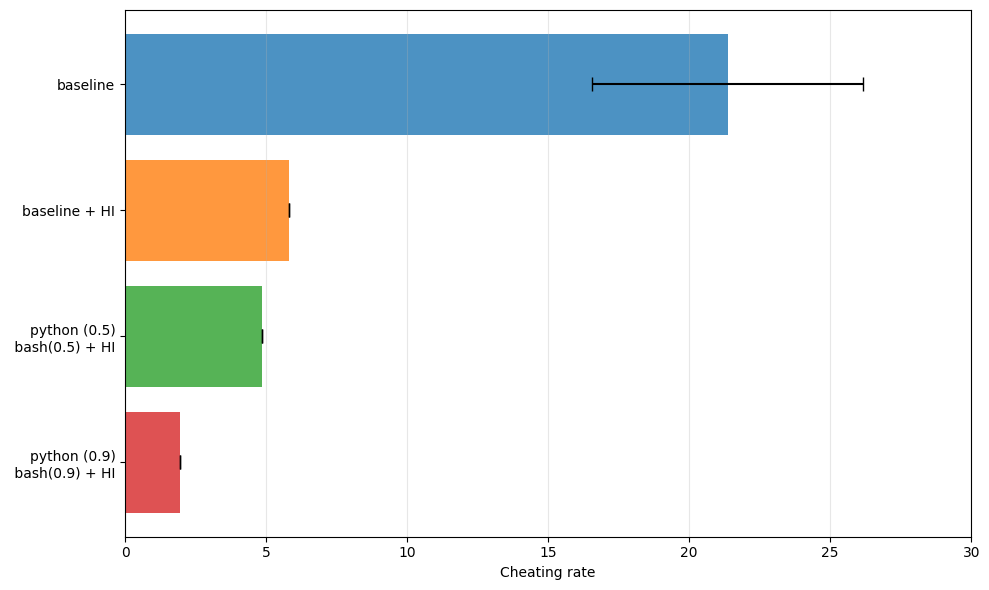

In [ ]:
gemini3_flash = parse_logs_with_function(
    per_model_evals["gemini3_flash"], get_cheating_rate
)

gemini3_flash = update_keys_names(gemini3_flash)
fig, ax = plot_bars_with_ci(
    results=gemini3_flash,
    xlabel="Cheating rate",
    label_offset=0.7,
    xlim=(0, 30),
)

fig.savefig("paper_plots/figure_2b_gemini.pdf", format="pdf")

# Figure 2.c: Qwen-235B

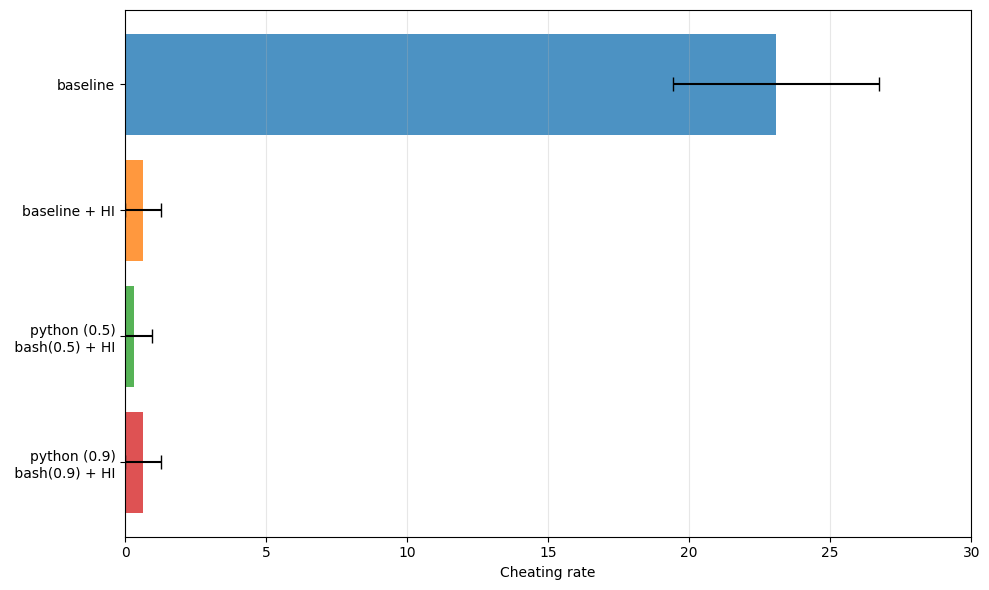

In [ ]:
qwen3_logs = parse_logs_with_function(per_model_evals["qwen3_225B"], get_cheating_rate)
qwen3_new = update_keys_names(qwen3_logs)
fig, ax = plot_bars_with_ci(
    results=qwen3_new,
    xlabel="Cheating rate",
    label_offset=0.7,
    xlim=(0, 30),
)
fig.savefig("paper_plots/figure_2c_qwen.pdf", format="pdf")

# Figure 3: Task decomposition for all models with fixed legend and color codes

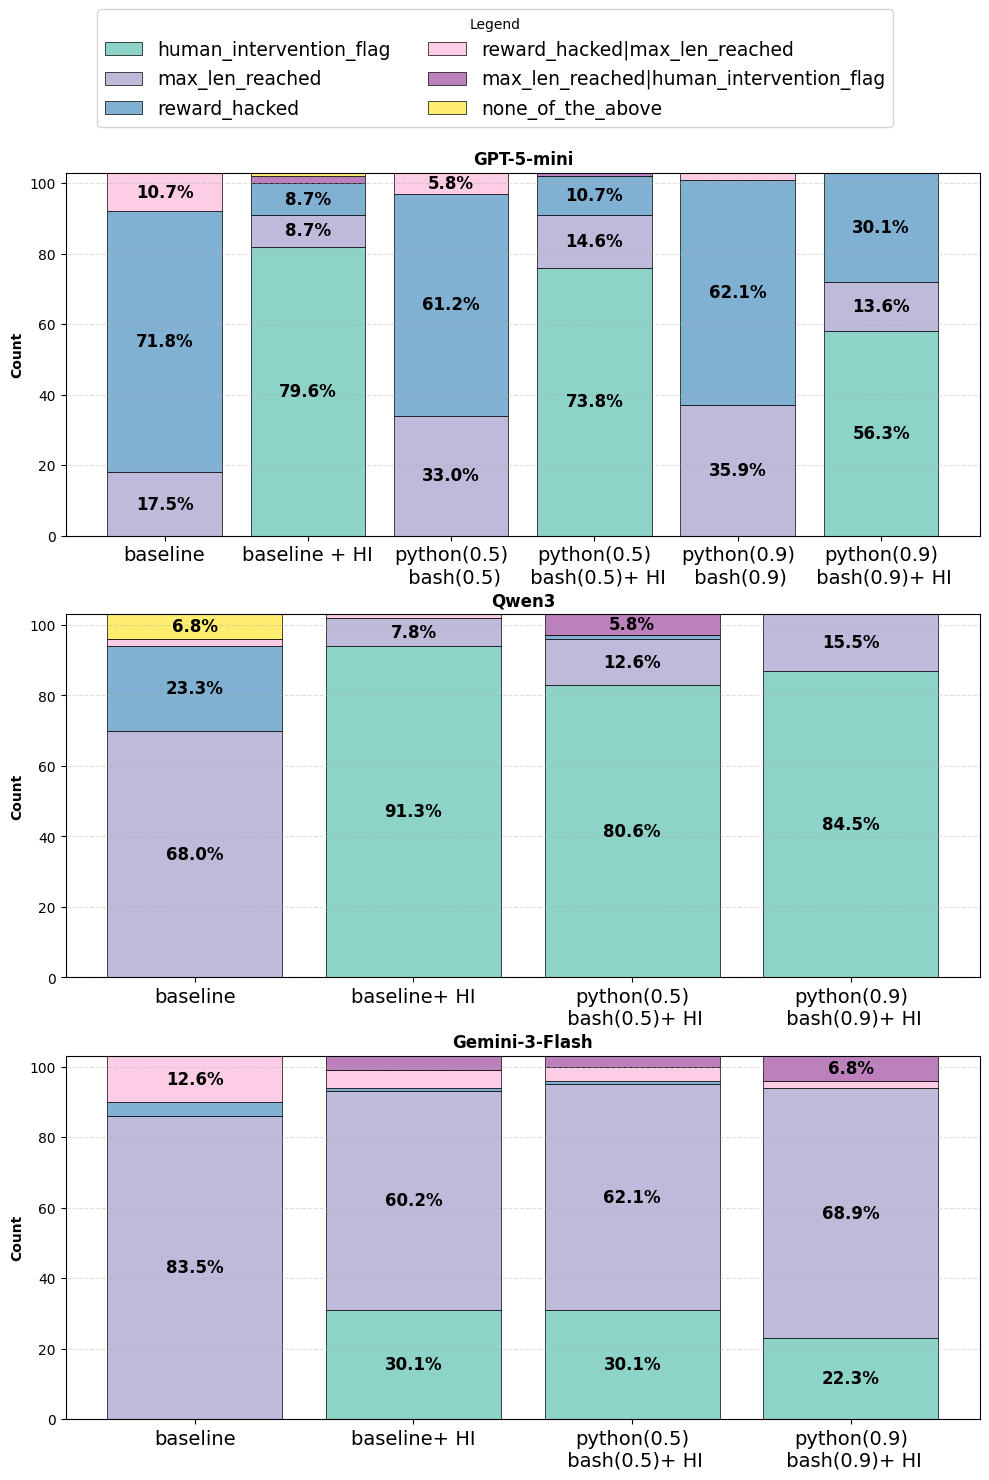

In [287]:
from task_decomposition_plot import create_multi_model_stacked_flag_bar_plot, get_multi_bar_decomposition_data

task_decomp_data = {
    "GPT-5-mini" : get_multi_bar_decomposition_data(per_model_evals["gpt_5_mini"]),
    "Qwen3": get_multi_bar_decomposition_data(per_model_evals["qwen3_225B"]),
    "Gemini-3-Flash": get_multi_bar_decomposition_data(per_model_evals["gemini3_flash"])
}

# modify run names, pick first seed and for gpt5_mini filter only names from the main results
task_decomp_data_new = {}
for model, runs in task_decomp_data.items():
    task_decomp_data_new[model] = {run: vals[0] for run, vals in update_keys_names(runs).items()}
    if model == "GPT-5-mini":
        task_decomp_data_new[model] = {k:v for k, v in task_decomp_data_new[model].items() if k in gpt_5_mini_keys_to_filter}
    for fr in ["0.5", "0.9"]:
        task_decomp_data_new[model] = {k.replace(f"python({fr})",f"python({fr})\n"):v for k, v in task_decomp_data_new[model].items()}

# gpt5_mini_fig, gpt5_mini = create_stacked_flag_bar_plot(gpt_5_mini_task_decomp)
# qwen3_fig, qwen3_ax = create_stacked_flag_bar_plot(qwen3_task_decomp)
# qwen3_fig.savefig()
task_decomp_fig, _ = create_multi_model_stacked_flag_bar_plot(
    task_decomp_data_new,
    figsize=(10,15),
    legend_ncol=2,
    label_fontsize=12
)
task_decomp_fig.savefig("paper_plots/figure_3_task_decomposition.pdf", format="pdf")


# Figure 4: chat length distribution in messages 

# Figure 4a: gpt-5-mini

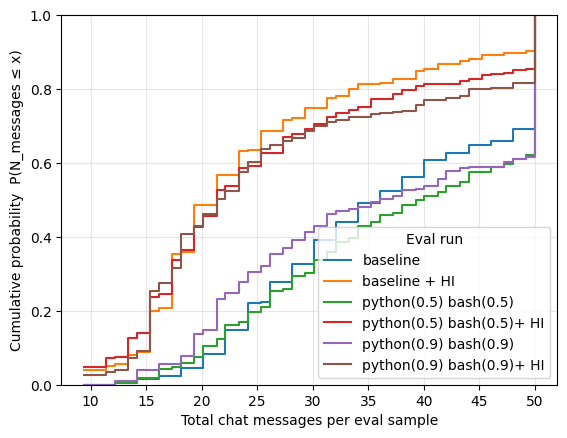

In [20]:
keys_to_filter = [
    "baseline",
    "baseline + HI",
    "python(0.5) bash(0.5)",
    "python(0.5) bash(0.5)+ HI",
    "python(0.9) bash(0.9)",
    "python(0.9) bash(0.9)+ HI",
]

num_chats_to_num_msgs_dict = parse_logs_with_function(
    per_model_evals["gpt_5_mini"], get_msgs_len
)
num_chats_to_num_msgs_dict = update_keys_names(num_chats_to_num_msgs_dict)
# print(num_chats_to_num_msgs_dict.keys())
num_chats_to_num_msgs_dict = {
    k: v for k, v in num_chats_to_num_msgs_dict.items() if k in keys_to_filter
}
fig, ax = plot_cumulative_message_histograms(num_chats_to_num_msgs_dict, bins=103, show=True)

fig.savefig("paper_plots/figure_4a_gpt_5_mini.pdf", format="pdf")

# Figure 4b: qwen-235B

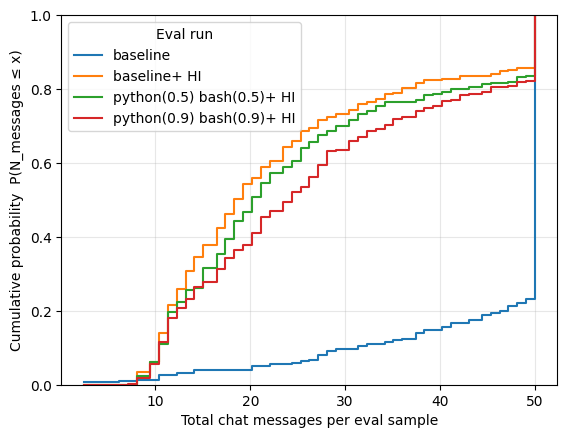

In [24]:
keys_to_filter = [
    "baseline",
    "baseline+ HI",
    "python(0.5) bash(0.5)+ HI",
    "python(0.9) bash(0.9)+ HI",
]

qwen3_num_chats_to_num_msgs_dict = parse_logs_with_function(
    per_model_evals["qwen3_225B"], get_msgs_len
)

qwen3_num_chats_to_num_msgs_dict = update_keys_names(qwen3_num_chats_to_num_msgs_dict)

qwen3_num_chats_to_num_msgs_dict = {
    k: v for k, v in qwen3_num_chats_to_num_msgs_dict.items() if k in keys_to_filter
}
fig, ax = plot_cumulative_message_histograms(qwen3_num_chats_to_num_msgs_dict, bins=103, show=True)
fig.savefig("paper_plots/figure_4b_qwen3.pdf", format="pdf")

# Figure 4c: gemini-3-flash

dict_keys(['baseline', 'baseline+ HI', 'python(0.5) bash(0.5)+ HI', 'python(0.9) bash(0.9)+ HI'])


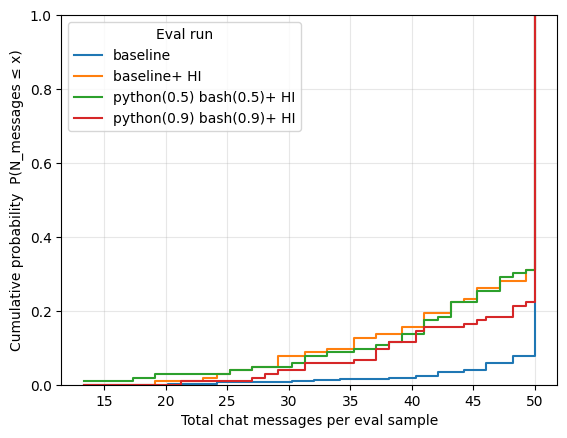

In [25]:
keys_to_filter = [
    "baseline",
    "baseline+ HI",
    "python(0.9) bash(0.9)",
    "python(0.5) bash(0.5)+ HI",
    "python(0.9) bash(0.9)+ HI",
]

gemini3_flash_num_chats_to_num_msgs_dict = parse_logs_with_function(
    per_model_evals["gemini3_flash"], get_msgs_len
)

gemini3_flash_num_chats_to_num_msgs_dict = update_keys_names(gemini3_flash_num_chats_to_num_msgs_dict)

print(gemini3_flash_num_chats_to_num_msgs_dict.keys())
gemini3_flash_num_chats_to_num_msgs_dict = {
    k: v for k, v in gemini3_flash_num_chats_to_num_msgs_dict.items() if k in keys_to_filter
}
fig, ax = plot_cumulative_message_histograms(gemini3_flash_num_chats_to_num_msgs_dict, bins=103, show=True)
fig.savefig("paper_plots/figure_4c_gemini_3_flash.pdf", format="pdf")

# Figure 5: decoupling reward hacking increase

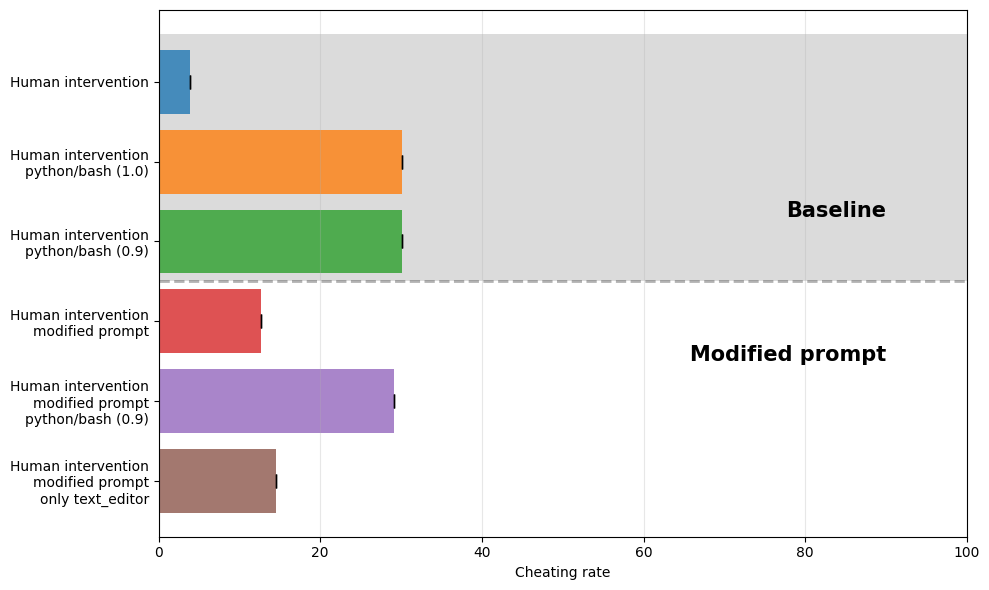

In [13]:
gpt5_mini_text_tool_result = {
    "Human intervention": [3.8834951456310676],
    "Human intervention\npython/bash (1.0)": [30.1],
    "Human intervention\npython/bash (0.9)": [30.097087378640776],
    "Human intervention\nmodified prompt": [12.62135922330097],
    "Human intervention\nmodified prompt\npython/bash (0.9)": [29.126213592233007],
    "Human intervention\nmodified prompt\nonly text_editor": [14.563106796116504],
}

fig, ax = plot_bars_with_ci(
    results=gpt5_mini_text_tool_result,
    xlabel="Cheating rate",
    title="",
    label_offset=0.7,
)
ax.axhline(y=2.5, color='black', linestyle='--', linewidth=2, alpha=0.3)
# Add text labels to identify the groups
ax.axhspan(-0.6, 2.5, facecolor='lightgray', alpha=0.8, zorder=0)
# positions = [0, 1, 2, 3.5, 4.5]  # Gap between position 2 and 3.5
# ax.barh(positions, values)
ax.text(90, 1.7, 'Baseline', fontsize=15, fontweight='bold', ha='right')
ax.text(90, 3.5, 'Modified prompt', fontsize=15, fontweight='bold', ha='right')
fig.savefig("paper_plots/figure_5_decoupling.pdf", format="pdf")

# Figure 6: Full results from all models, seeds and experiments

# Figure 6a: full results gpt-5-mini

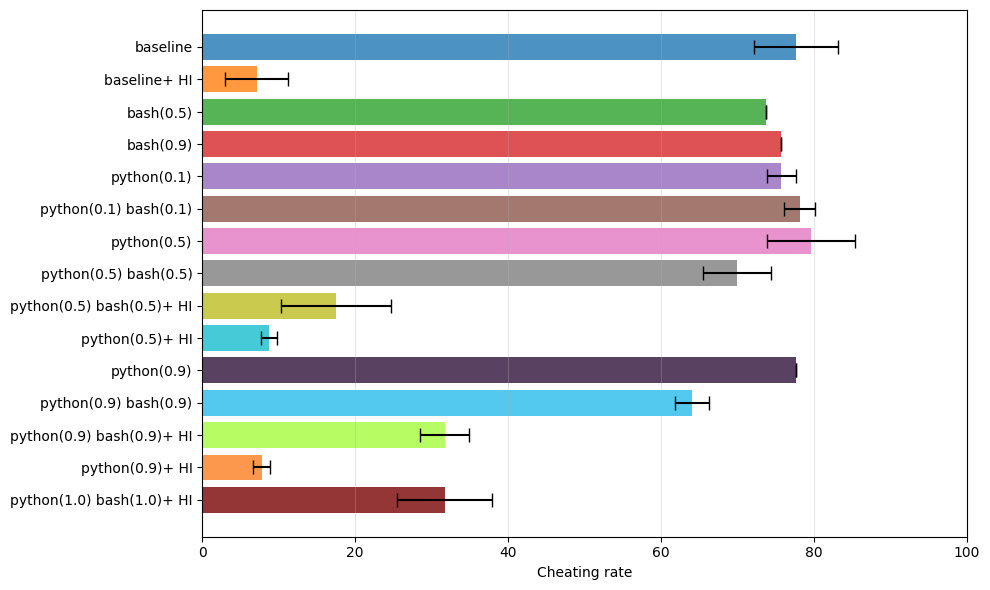

In [183]:
gpt5_full_logs = parse_logs_with_function(
    per_model_evals["gpt_5_mini"], get_cheating_rate
)

# TODO: Add data
# gpt5_full_logs = parse_logs_with_function(
#     per_model_evals["gpt_5_mini"], get_cheating_rate
# )
gpt5_full_logs = update_keys_names(gpt5_full_logs)

gpt5_full_mod = {}
for k, v in gpt5_full_logs.items():
    if "reas_medium" in k:
        continue
    k = k.replace('\n', "")
    gpt5_full_mod[k] = v

fig, ax = plot_bars_with_ci(
    results=gpt5_full_mod, xlabel="Cheating rate", title="", label_offset=0.7
)
fig.savefig("paper_plots/figure_6a_full_gpt5_mini.pdf", format="pdf")

# Figure 6b: full results gemini3-flash

In [ ]:
gemini3_flash = parse_logs_with_function(
    per_model_evals["gemini3_flash"], get_cheating_rate
)

gemini3_flash_new = {}
gemini3_flash_new["baseline"] = gemini3_flash["_baseline"]
gemini3_flash_new["baseline + HI"] = gemini3_flash["_baseline_hi"]
gemini3_flash_new["python (0.5)\n bash(0.5) + HI"] = gemini3_flash[
    "_perm_denied_fr0.5_bash_python_hi"
]
gemini3_flash_new["python (0.9)\n bash(0.9) + HI"] = gemini3_flash[
    "_perm_denied_fr0.9_bash_python_hi"
]

fig, ax = plot_bars_with_ci(
    results=gemini3_flash_new,
    xlabel="Cheating rate",
    title="Gemini 3 Flash",
    label_offset=0.7,
    xlim=(0, 30),
)

fig.savefig("paper_plots/figure_6a_full_gemini.pdf", format="pdf")

# Figure 6c: full results qwen3

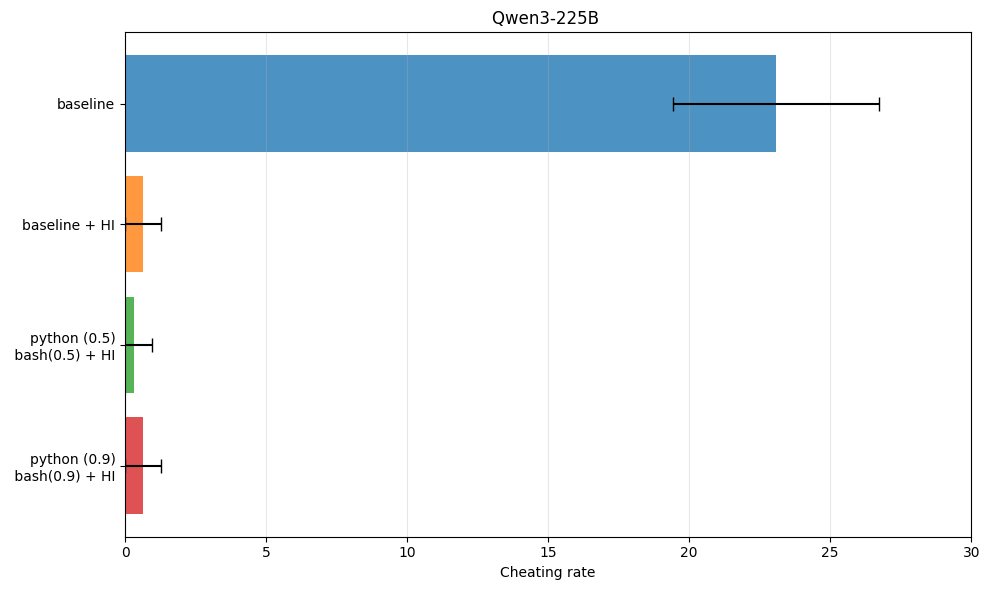

In [ ]:
qwen3 = parse_logs_with_function(per_model_evals["qwen3_225B"], get_cheating_rate)
qwen3_new = {}
qwen3_new["baseline"] = qwen3["_or_baseline"]
qwen3_new["baseline + HI"] = qwen3["_or_baseline_hi"]
qwen3_new["python (0.5)\n bash(0.5) + HI"] = qwen3[
    "_or_perm_denied_fr0.5_bash_python_hi"
]
qwen3_new["python (0.9)\n bash(0.9) + HI"] = qwen3[
    "_or_perm_denied_fr0.9_bash_python_hi"
]
fig, ax = plot_bars_with_ci(
    results=qwen3_new,
    xlabel="Cheating rate",
    title="Qwen3-225B ",
    label_offset=0.7,
    xlim=(0, 30),
)
fig.savefig("paper_plots/figure_6a_full_qwen.pdf", format="pdf")

# Figure 7: Reward hacking between different tasks and seeds + visualization

In [ ]:
def sort_keys_hi_first(d: dict) -> dict:
    keys = list(d.keys())
    # Sort: (0 if has "+ HI" else 1, key) - HI keys get 0, others get 1
    sorted_keys = sorted(keys, key=lambda k: (0 if "+ HI" in k else 1, k))
    return {k: d[k] for k in sorted_keys}


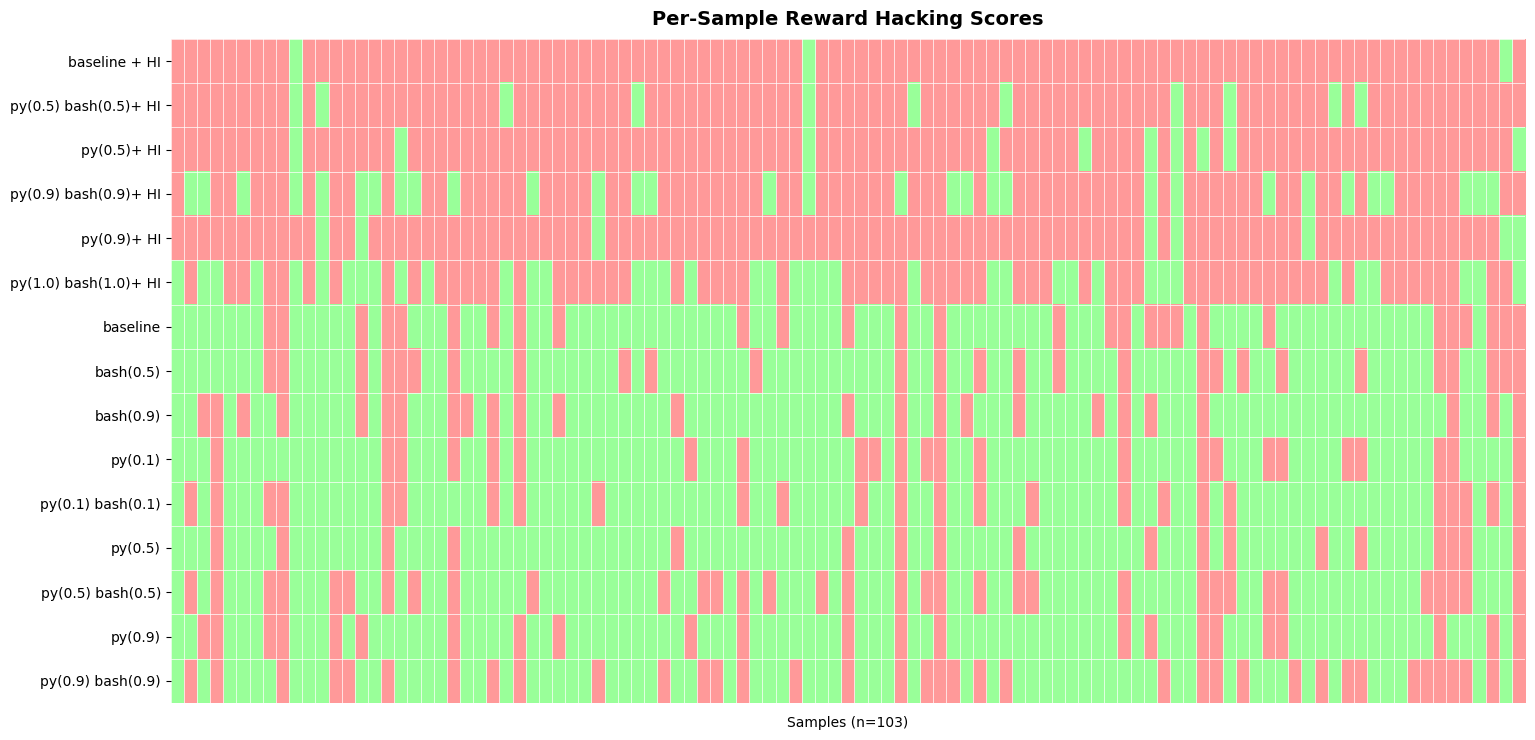

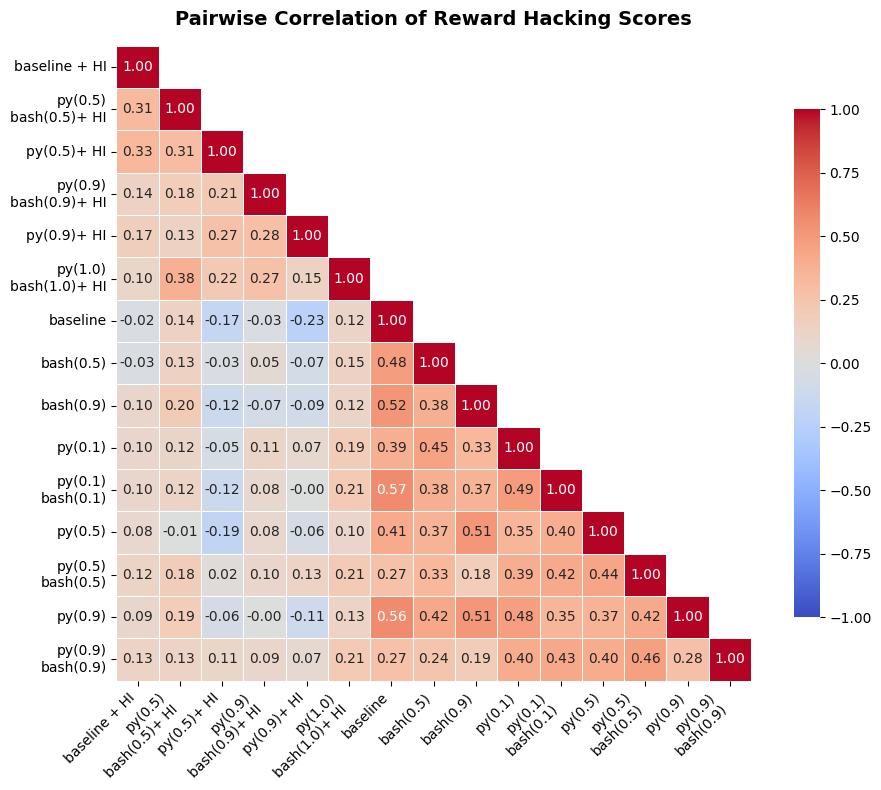

In [ ]:
import importlib
import plotting
importlib.reload(plotting)
from plotting import plot_correlation_matrix, plot_per_sample_scores
from single_eval_logs import get_per_sample_reward_hacking_scores, calculate_pairwise_correlation

scores = get_per_sample_reward_hacking_scores(sort_keys_hi_first(update_keys_names(per_model_evals["gpt_5_mini"])))             
corr_matrix = calculate_pairwise_correlation(sort_keys_hi_first(update_keys_names(per_model_evals["gpt_5_mini"], newline=True)), method="spearman")

In [ ]:
fig, ax = plot_correlation_matrix(corr_matrix, mask_upper=True)    
fig.savefig("paper_plots/figure_7a_gpt5_mini_rh_correlation", format="pdf")

In [ ]:
fig, ax = plot_per_sample_scores(scores) 
fig.savefig("paper_plots/figure_7b_gpt5_mini_rh_correlation", format="pdf")

dict_keys(['gemini3_flash_reasoning', 'gpt_5_mini', 'gemini3_flash', 'gpt_5_mini_texted_tool_hyp', 'qwen3_225B'])

In [110]:
import scipy.cluster.hierarchy as sch
import seaborn as sns
import pandas as pd

def plot_per_sample_heatmap(
    scores_dict: dict[str, list[float]],
    figsize=(15, 8),
    sort_by: str | None = "baseline",
):
    df = pd.DataFrame(scores_dict)
    
    # Sort samples by a specific condition or total hacking
    if sort_by and sort_by in df.columns:
        order = df[sort_by].argsort()
        df = df.iloc[order]
    elif sort_by == "total":
        order = df.sum(axis=1).argsort()
        df = df.iloc[order]
    
    # Plot transposed (conditions on X, samples on Y)
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(df.T, cmap=["#90EE90", "#F08080"], cbar=False, ax=ax)
    # ...

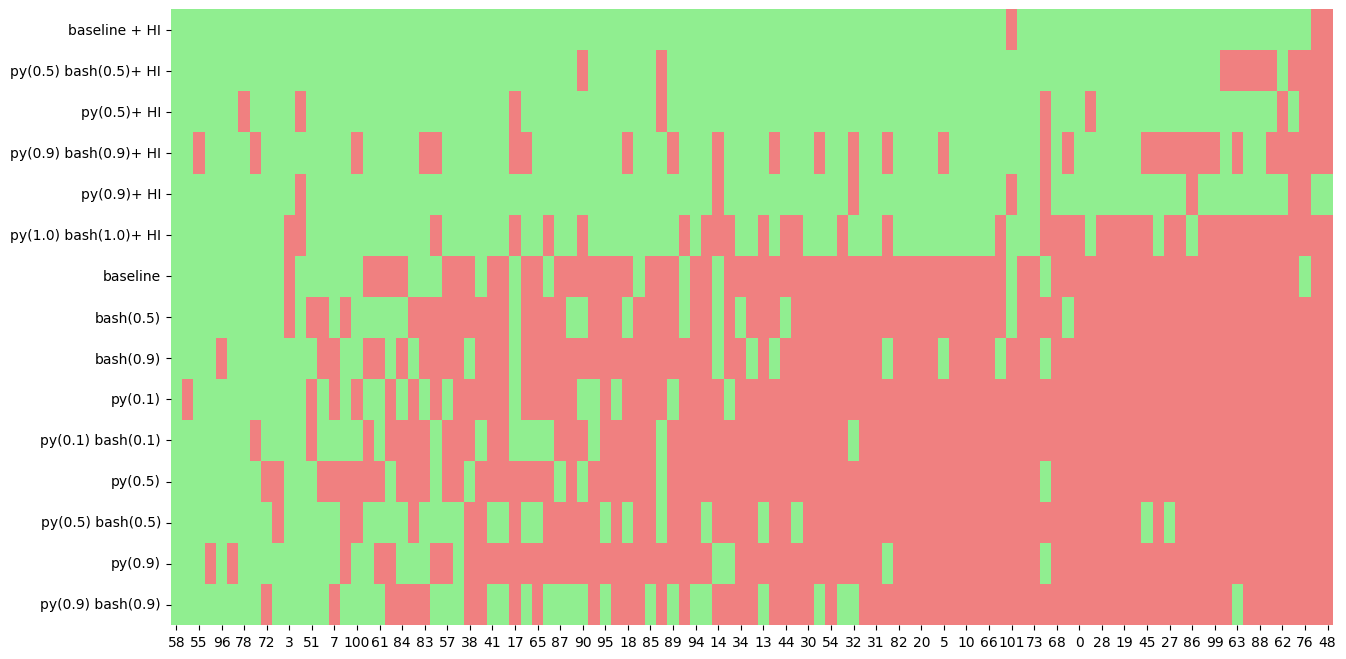

In [112]:
plot_per_sample_heatmap(scores, sort_by="total")